Cosumnes Model 
@author: Andrew

In [1]:
# standard python utilities
import os
import sys
import glob
import pandas as pd
import numpy as np
import calendar
import time
from scipy.stats import gmean

# standard python plotting utilities
import matplotlib as mpl
import matplotlib.pyplot as plt

# standard geospatial python utilities
import pyproj # for converting proj4string
import shapely
import geopandas as gpd
import rasterio

# mapping utilities
import contextily as ctx
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm

In [2]:

# run installed version of flopy or add local path
try:
    import flopy
    from flopy.discretization.structuredgrid import StructuredGrid
    from flopy.utils.reference import SpatialReference
    from flopy.utils import Raster
except:
    import flopy
    fpth = os.path.abspath(os.path.join('..', '..'))
    sys.path.append(fpth)
    from flopy.discretization.structuredgrid import StructuredGrid
    from flopy.utils.reference import SpatialReference
    from flopy.utils import Raster
from flopy.utils.gridgen import Gridgen
from flopy.utils import OptionBlock
import flopy.utils.binaryfile as bf


print(sys.version)
print('numpy version: {}'.format(np.__version__))
print('matplotlib version: {}'.format(mpl.__version__))
print('flopy version: {}'.format(flopy.__version__))

3.7.11 (default, Jul 27 2021, 09:42:29) [MSC v.1916 64 bit (AMD64)]
numpy version: 1.21.2
matplotlib version: 3.5.0
flopy version: 3.3.4


In [3]:
## Set up directory referencing
# Package data
git_dir = os.path.dirname(os.path.dirname(os.getcwd()))
gwfm_dir = '\\'.join(str.split(git_dir,'\\')[0:3])+ '/Box/research_cosumnes/GWFlowModel'
print(git_dir, gwfm_dir)

C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge\Projects C:\Users\ajcalder/Box/research_cosumnes/GWFlowModel


## Individual Users may change loadpath 
The default loadpath is set to an existing external hard drive for Andrew as F://
If the script doesn't find an external harddrive F:// then it will default to the C:// Drive in WRDAPP

In [4]:
ext_dir = 'F:/WRDAPP'
c_dir = 'C:/WRDAPP'

if os.path.exists(ext_dir):
    loadpth = ext_dir 
elif os.path.exists(c_dir):
    loadpth = c_dir 

loadpth = loadpth +'/GWFlowModel/Cosumnes/levee_setback/setback_distance_analysis/'
model_ws = loadpth+'Permeameter_for_velocity'
print(model_ws)

F:/WRDAPP/GWFlowModel/Cosumnes/levee_setback/setback_distance_analysis/Permeameter_for_velocity


In [5]:
m = flopy.modflow.Modflow.load('MF.nam',model_ws = model_ws)

## Create 100 runs
Copy existing modflow run folder 100 times with CHD, PCGN, BAS, OC, NAM, DIS
Then iterate over the 100 TPROGs realizations making a new LPF package in each folder

In [6]:
pks = ['chd','dis','pcgn','bas','oc','nam']
files = [glob.glob(model_ws+'/*'+p)[0] for p in pks]


In [54]:
import shutil, os

for n in np.arange(0,100).astype(str):
    for f in files:
        folder = '/realization'+ n.zfill(3)+'/'
        os.makedirs(model_ws+folder,exist_ok=True)
        shutil.copy(f, model_ws+folder)

In [7]:
model_ws

mf_tprogs_dir = gwfm_dir+'/UPW_data/tprogs_final/'
tprogs_files = glob.glob(mf_tprogs_dir+'*')


In [9]:
def int_to_param(tprogs, params):
    """
    Parameters
    ----------
    tprogs: 3D masked array of TPROGs realization
    params: Reference table connecting TPROGs facie to a hydraulic value
    """
    tprogs[tprogs<0] *= -1
    tprogs = tprogs.astype(float)
    # flip tprogs model along z axis to match modflow definition of 0 as top (TPROGS says 0 is bottom)
    tprogs = np.flip(tprogs,axis=0)
    tprogs_K = np.copy(tprogs)
    tprogs_Sy = np.copy(tprogs)
    tprogs_Ss = np.copy(tprogs)
    # hydraulic parameters from fleckenstein 2006
    # I-IV gravel, sand, muddy sand, mud
    # K in m/s, Sy, Ss
    for n in np.arange(1,5):
        tprogs_K[tprogs==n]= params.loc[n,'K_m_d']
    for n in np.arange(1,5):
        tprogs_Sy[tprogs==n]= params.loc[n,'Sy']
    for n in np.arange(1,5):
        tprogs_Ss[tprogs==n]= params.loc[n,'Ss']
            
    return(tprogs_K,tprogs_Sy,tprogs_Ss)

In [11]:
gel_dir = gwfm_dir+'/UPW_data'
params = pd.read_csv(model_ws+'/ZonePropertiesInitial.csv',index_col='Zone')

# convert from m/s to m/d
params['K_m_d'] = params.K_m_s * 86400 

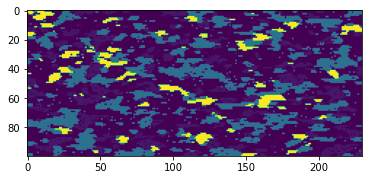


changing model workspace...
   F:/WRDAPP/GWFlowModel/Cosumnes/levee_setback/setback_distance_analysis/Permeameter_for_velocity/realization000/


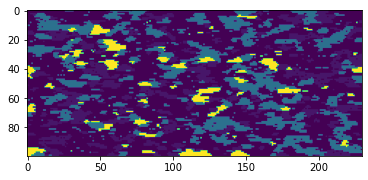


changing model workspace...
   F:/WRDAPP/GWFlowModel/Cosumnes/levee_setback/setback_distance_analysis/Permeameter_for_velocity/realization001/


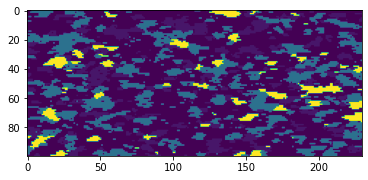


changing model workspace...
   F:/WRDAPP/GWFlowModel/Cosumnes/levee_setback/setback_distance_analysis/Permeameter_for_velocity/realization002/


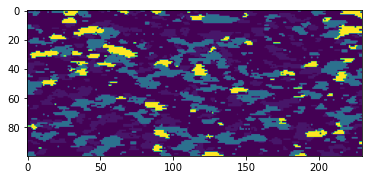


changing model workspace...
   F:/WRDAPP/GWFlowModel/Cosumnes/levee_setback/setback_distance_analysis/Permeameter_for_velocity/realization003/


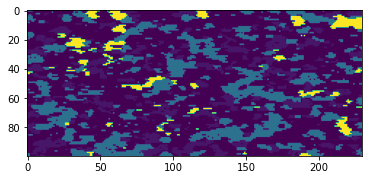


changing model workspace...
   F:/WRDAPP/GWFlowModel/Cosumnes/levee_setback/setback_distance_analysis/Permeameter_for_velocity/realization004/


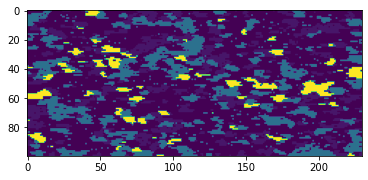


changing model workspace...
   F:/WRDAPP/GWFlowModel/Cosumnes/levee_setback/setback_distance_analysis/Permeameter_for_velocity/realization005/


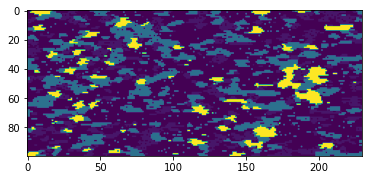


changing model workspace...
   F:/WRDAPP/GWFlowModel/Cosumnes/levee_setback/setback_distance_analysis/Permeameter_for_velocity/realization006/


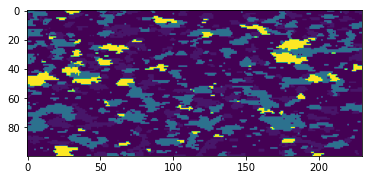


changing model workspace...
   F:/WRDAPP/GWFlowModel/Cosumnes/levee_setback/setback_distance_analysis/Permeameter_for_velocity/realization007/


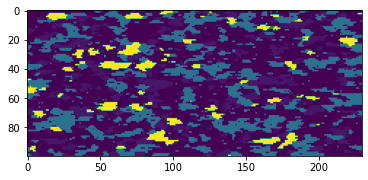


changing model workspace...
   F:/WRDAPP/GWFlowModel/Cosumnes/levee_setback/setback_distance_analysis/Permeameter_for_velocity/realization008/


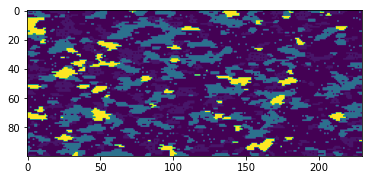


changing model workspace...
   F:/WRDAPP/GWFlowModel/Cosumnes/levee_setback/setback_distance_analysis/Permeameter_for_velocity/realization009/


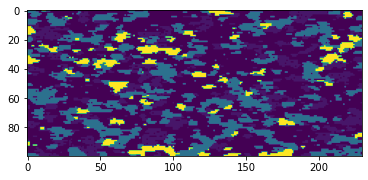


changing model workspace...
   F:/WRDAPP/GWFlowModel/Cosumnes/levee_setback/setback_distance_analysis/Permeameter_for_velocity/realization010/


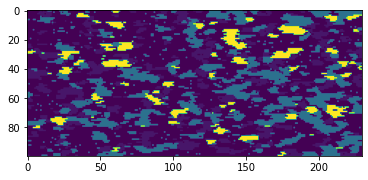


changing model workspace...
   F:/WRDAPP/GWFlowModel/Cosumnes/levee_setback/setback_distance_analysis/Permeameter_for_velocity/realization011/


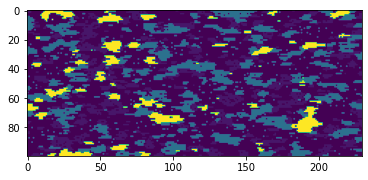


changing model workspace...
   F:/WRDAPP/GWFlowModel/Cosumnes/levee_setback/setback_distance_analysis/Permeameter_for_velocity/realization012/


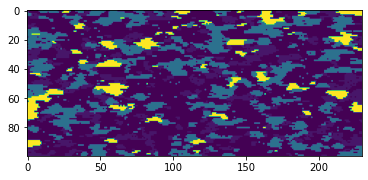


changing model workspace...
   F:/WRDAPP/GWFlowModel/Cosumnes/levee_setback/setback_distance_analysis/Permeameter_for_velocity/realization013/


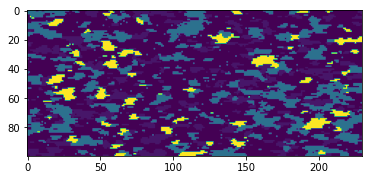


changing model workspace...
   F:/WRDAPP/GWFlowModel/Cosumnes/levee_setback/setback_distance_analysis/Permeameter_for_velocity/realization014/


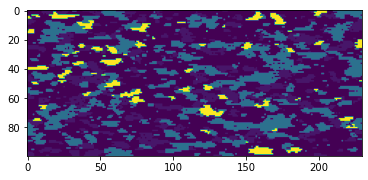


changing model workspace...
   F:/WRDAPP/GWFlowModel/Cosumnes/levee_setback/setback_distance_analysis/Permeameter_for_velocity/realization015/


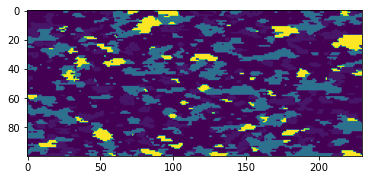


changing model workspace...
   F:/WRDAPP/GWFlowModel/Cosumnes/levee_setback/setback_distance_analysis/Permeameter_for_velocity/realization016/


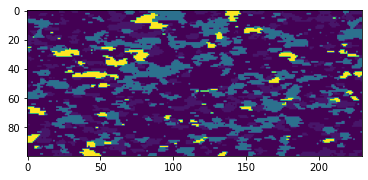


changing model workspace...
   F:/WRDAPP/GWFlowModel/Cosumnes/levee_setback/setback_distance_analysis/Permeameter_for_velocity/realization017/


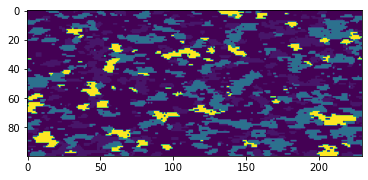


changing model workspace...
   F:/WRDAPP/GWFlowModel/Cosumnes/levee_setback/setback_distance_analysis/Permeameter_for_velocity/realization018/


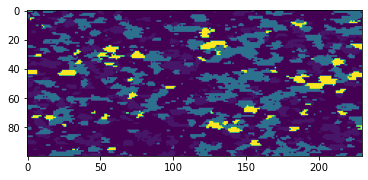


changing model workspace...
   F:/WRDAPP/GWFlowModel/Cosumnes/levee_setback/setback_distance_analysis/Permeameter_for_velocity/realization019/


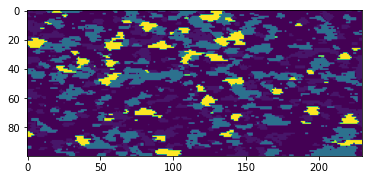


changing model workspace...
   F:/WRDAPP/GWFlowModel/Cosumnes/levee_setback/setback_distance_analysis/Permeameter_for_velocity/realization020/


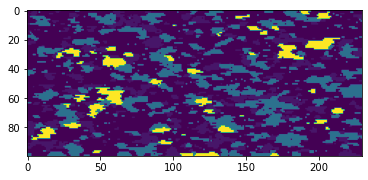


changing model workspace...
   F:/WRDAPP/GWFlowModel/Cosumnes/levee_setback/setback_distance_analysis/Permeameter_for_velocity/realization021/


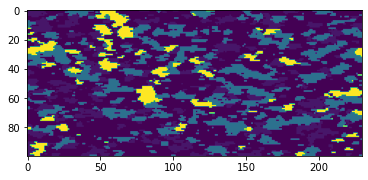


changing model workspace...
   F:/WRDAPP/GWFlowModel/Cosumnes/levee_setback/setback_distance_analysis/Permeameter_for_velocity/realization022/


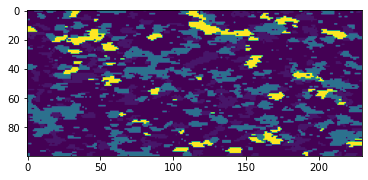


changing model workspace...
   F:/WRDAPP/GWFlowModel/Cosumnes/levee_setback/setback_distance_analysis/Permeameter_for_velocity/realization023/


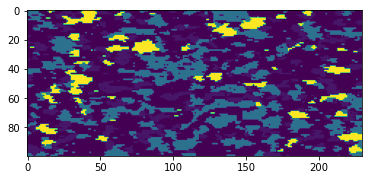


changing model workspace...
   F:/WRDAPP/GWFlowModel/Cosumnes/levee_setback/setback_distance_analysis/Permeameter_for_velocity/realization024/


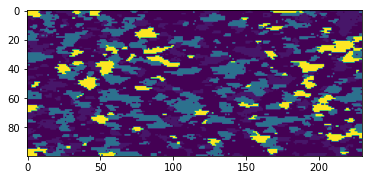


changing model workspace...
   F:/WRDAPP/GWFlowModel/Cosumnes/levee_setback/setback_distance_analysis/Permeameter_for_velocity/realization025/


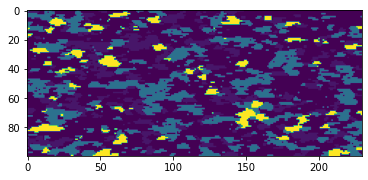


changing model workspace...
   F:/WRDAPP/GWFlowModel/Cosumnes/levee_setback/setback_distance_analysis/Permeameter_for_velocity/realization026/


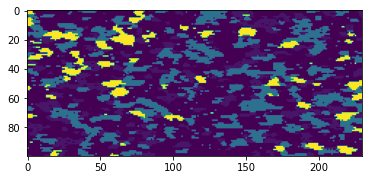


changing model workspace...
   F:/WRDAPP/GWFlowModel/Cosumnes/levee_setback/setback_distance_analysis/Permeameter_for_velocity/realization027/


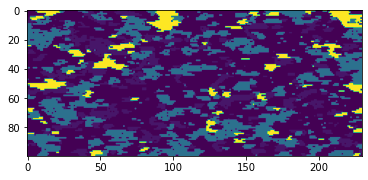


changing model workspace...
   F:/WRDAPP/GWFlowModel/Cosumnes/levee_setback/setback_distance_analysis/Permeameter_for_velocity/realization028/


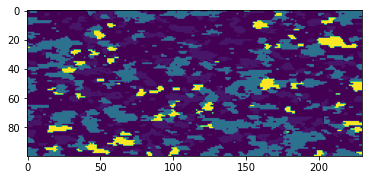


changing model workspace...
   F:/WRDAPP/GWFlowModel/Cosumnes/levee_setback/setback_distance_analysis/Permeameter_for_velocity/realization029/


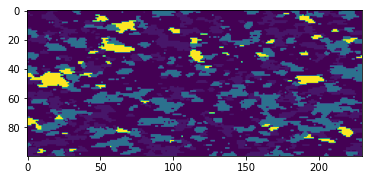


changing model workspace...
   F:/WRDAPP/GWFlowModel/Cosumnes/levee_setback/setback_distance_analysis/Permeameter_for_velocity/realization030/


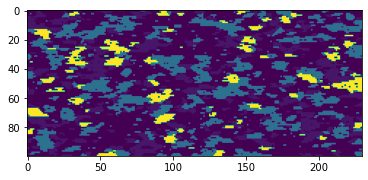


changing model workspace...
   F:/WRDAPP/GWFlowModel/Cosumnes/levee_setback/setback_distance_analysis/Permeameter_for_velocity/realization031/


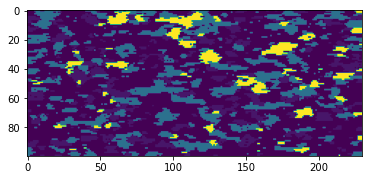


changing model workspace...
   F:/WRDAPP/GWFlowModel/Cosumnes/levee_setback/setback_distance_analysis/Permeameter_for_velocity/realization032/


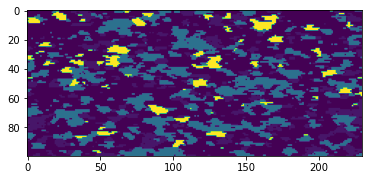


changing model workspace...
   F:/WRDAPP/GWFlowModel/Cosumnes/levee_setback/setback_distance_analysis/Permeameter_for_velocity/realization033/


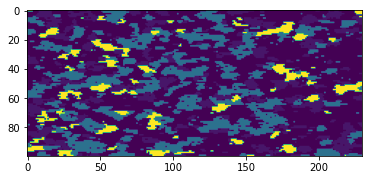


changing model workspace...
   F:/WRDAPP/GWFlowModel/Cosumnes/levee_setback/setback_distance_analysis/Permeameter_for_velocity/realization034/


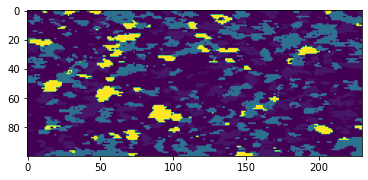


changing model workspace...
   F:/WRDAPP/GWFlowModel/Cosumnes/levee_setback/setback_distance_analysis/Permeameter_for_velocity/realization035/


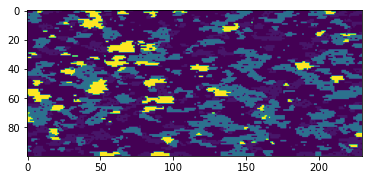


changing model workspace...
   F:/WRDAPP/GWFlowModel/Cosumnes/levee_setback/setback_distance_analysis/Permeameter_for_velocity/realization036/


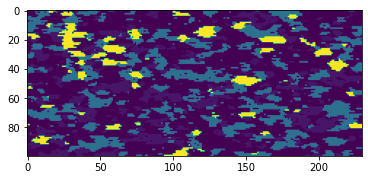


changing model workspace...
   F:/WRDAPP/GWFlowModel/Cosumnes/levee_setback/setback_distance_analysis/Permeameter_for_velocity/realization037/


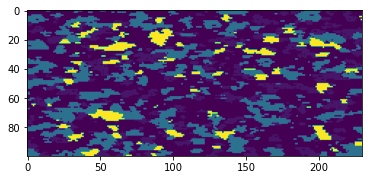


changing model workspace...
   F:/WRDAPP/GWFlowModel/Cosumnes/levee_setback/setback_distance_analysis/Permeameter_for_velocity/realization038/


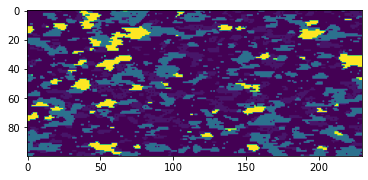


changing model workspace...
   F:/WRDAPP/GWFlowModel/Cosumnes/levee_setback/setback_distance_analysis/Permeameter_for_velocity/realization039/


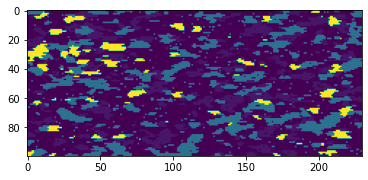


changing model workspace...
   F:/WRDAPP/GWFlowModel/Cosumnes/levee_setback/setback_distance_analysis/Permeameter_for_velocity/realization040/


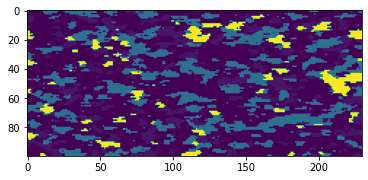


changing model workspace...
   F:/WRDAPP/GWFlowModel/Cosumnes/levee_setback/setback_distance_analysis/Permeameter_for_velocity/realization041/


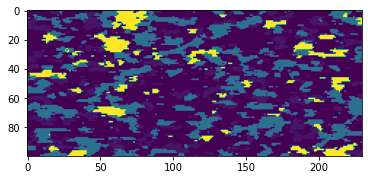


changing model workspace...
   F:/WRDAPP/GWFlowModel/Cosumnes/levee_setback/setback_distance_analysis/Permeameter_for_velocity/realization042/


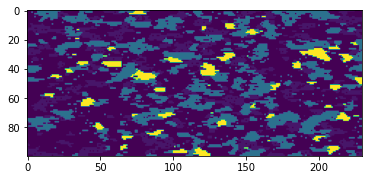


changing model workspace...
   F:/WRDAPP/GWFlowModel/Cosumnes/levee_setback/setback_distance_analysis/Permeameter_for_velocity/realization043/


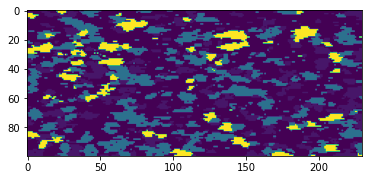


changing model workspace...
   F:/WRDAPP/GWFlowModel/Cosumnes/levee_setback/setback_distance_analysis/Permeameter_for_velocity/realization044/


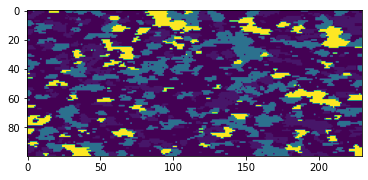


changing model workspace...
   F:/WRDAPP/GWFlowModel/Cosumnes/levee_setback/setback_distance_analysis/Permeameter_for_velocity/realization045/


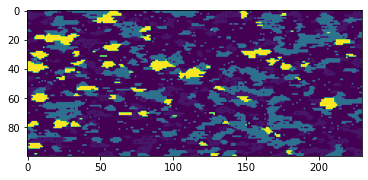


changing model workspace...
   F:/WRDAPP/GWFlowModel/Cosumnes/levee_setback/setback_distance_analysis/Permeameter_for_velocity/realization046/


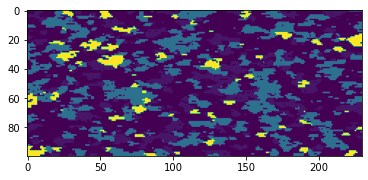


changing model workspace...
   F:/WRDAPP/GWFlowModel/Cosumnes/levee_setback/setback_distance_analysis/Permeameter_for_velocity/realization047/


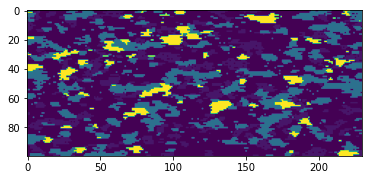


changing model workspace...
   F:/WRDAPP/GWFlowModel/Cosumnes/levee_setback/setback_distance_analysis/Permeameter_for_velocity/realization048/


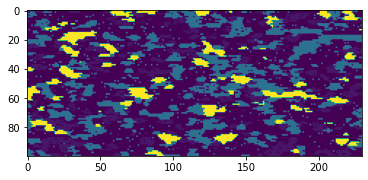


changing model workspace...
   F:/WRDAPP/GWFlowModel/Cosumnes/levee_setback/setback_distance_analysis/Permeameter_for_velocity/realization049/


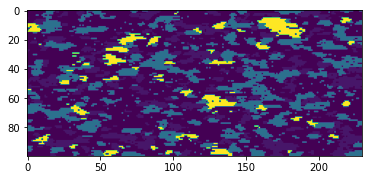


changing model workspace...
   F:/WRDAPP/GWFlowModel/Cosumnes/levee_setback/setback_distance_analysis/Permeameter_for_velocity/realization050/


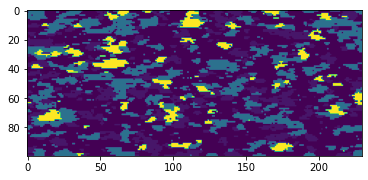


changing model workspace...
   F:/WRDAPP/GWFlowModel/Cosumnes/levee_setback/setback_distance_analysis/Permeameter_for_velocity/realization051/


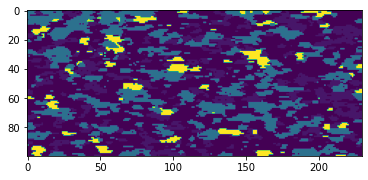


changing model workspace...
   F:/WRDAPP/GWFlowModel/Cosumnes/levee_setback/setback_distance_analysis/Permeameter_for_velocity/realization052/


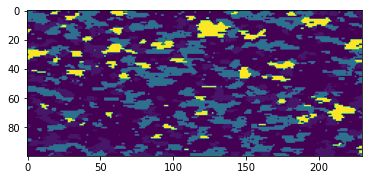


changing model workspace...
   F:/WRDAPP/GWFlowModel/Cosumnes/levee_setback/setback_distance_analysis/Permeameter_for_velocity/realization053/


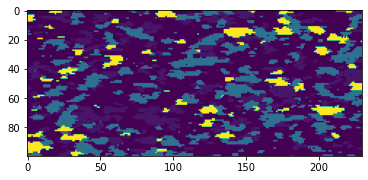


changing model workspace...
   F:/WRDAPP/GWFlowModel/Cosumnes/levee_setback/setback_distance_analysis/Permeameter_for_velocity/realization054/


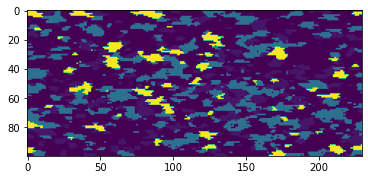


changing model workspace...
   F:/WRDAPP/GWFlowModel/Cosumnes/levee_setback/setback_distance_analysis/Permeameter_for_velocity/realization055/


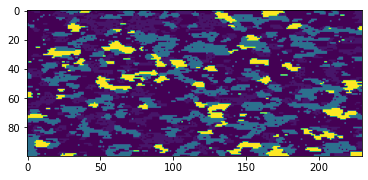


changing model workspace...
   F:/WRDAPP/GWFlowModel/Cosumnes/levee_setback/setback_distance_analysis/Permeameter_for_velocity/realization056/


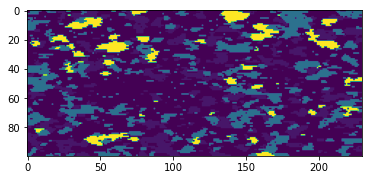


changing model workspace...
   F:/WRDAPP/GWFlowModel/Cosumnes/levee_setback/setback_distance_analysis/Permeameter_for_velocity/realization057/


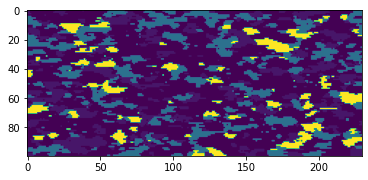


changing model workspace...
   F:/WRDAPP/GWFlowModel/Cosumnes/levee_setback/setback_distance_analysis/Permeameter_for_velocity/realization058/


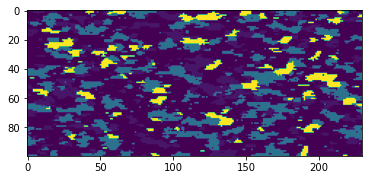


changing model workspace...
   F:/WRDAPP/GWFlowModel/Cosumnes/levee_setback/setback_distance_analysis/Permeameter_for_velocity/realization059/


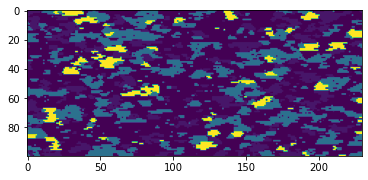


changing model workspace...
   F:/WRDAPP/GWFlowModel/Cosumnes/levee_setback/setback_distance_analysis/Permeameter_for_velocity/realization060/


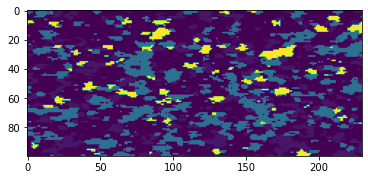


changing model workspace...
   F:/WRDAPP/GWFlowModel/Cosumnes/levee_setback/setback_distance_analysis/Permeameter_for_velocity/realization061/


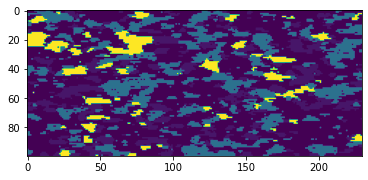


changing model workspace...
   F:/WRDAPP/GWFlowModel/Cosumnes/levee_setback/setback_distance_analysis/Permeameter_for_velocity/realization062/


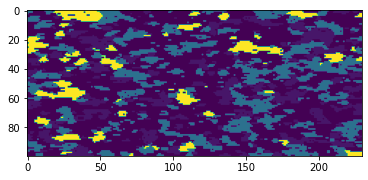


changing model workspace...
   F:/WRDAPP/GWFlowModel/Cosumnes/levee_setback/setback_distance_analysis/Permeameter_for_velocity/realization063/


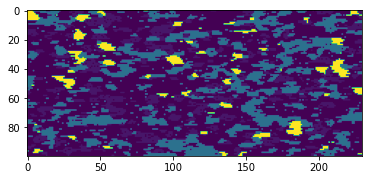


changing model workspace...
   F:/WRDAPP/GWFlowModel/Cosumnes/levee_setback/setback_distance_analysis/Permeameter_for_velocity/realization064/


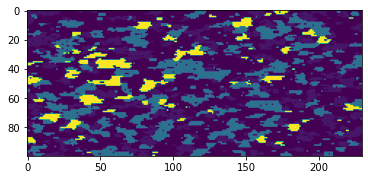


changing model workspace...
   F:/WRDAPP/GWFlowModel/Cosumnes/levee_setback/setback_distance_analysis/Permeameter_for_velocity/realization065/


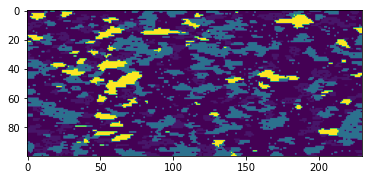


changing model workspace...
   F:/WRDAPP/GWFlowModel/Cosumnes/levee_setback/setback_distance_analysis/Permeameter_for_velocity/realization066/


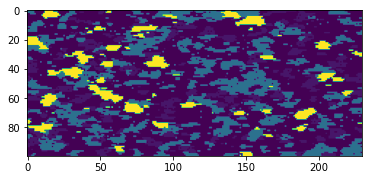


changing model workspace...
   F:/WRDAPP/GWFlowModel/Cosumnes/levee_setback/setback_distance_analysis/Permeameter_for_velocity/realization067/


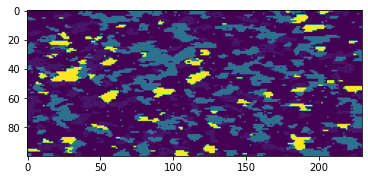


changing model workspace...
   F:/WRDAPP/GWFlowModel/Cosumnes/levee_setback/setback_distance_analysis/Permeameter_for_velocity/realization068/


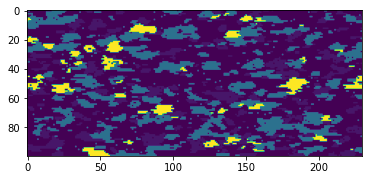


changing model workspace...
   F:/WRDAPP/GWFlowModel/Cosumnes/levee_setback/setback_distance_analysis/Permeameter_for_velocity/realization069/


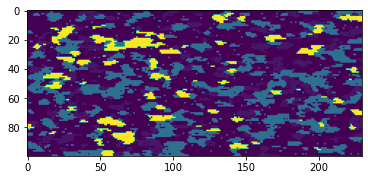


changing model workspace...
   F:/WRDAPP/GWFlowModel/Cosumnes/levee_setback/setback_distance_analysis/Permeameter_for_velocity/realization070/


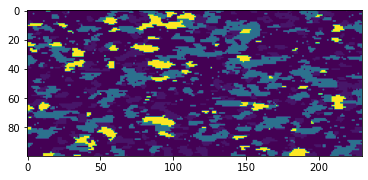


changing model workspace...
   F:/WRDAPP/GWFlowModel/Cosumnes/levee_setback/setback_distance_analysis/Permeameter_for_velocity/realization071/


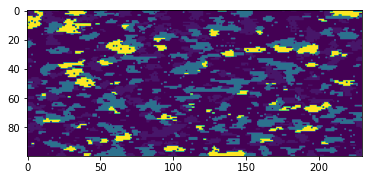


changing model workspace...
   F:/WRDAPP/GWFlowModel/Cosumnes/levee_setback/setback_distance_analysis/Permeameter_for_velocity/realization072/


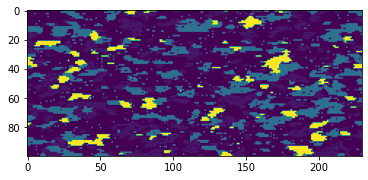


changing model workspace...
   F:/WRDAPP/GWFlowModel/Cosumnes/levee_setback/setback_distance_analysis/Permeameter_for_velocity/realization073/


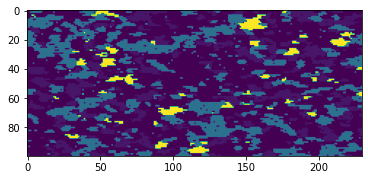


changing model workspace...
   F:/WRDAPP/GWFlowModel/Cosumnes/levee_setback/setback_distance_analysis/Permeameter_for_velocity/realization074/


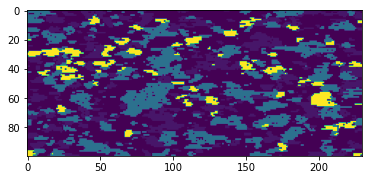


changing model workspace...
   F:/WRDAPP/GWFlowModel/Cosumnes/levee_setback/setback_distance_analysis/Permeameter_for_velocity/realization075/


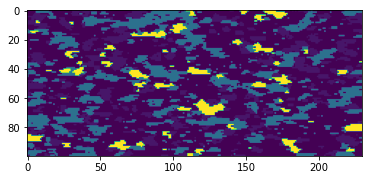


changing model workspace...
   F:/WRDAPP/GWFlowModel/Cosumnes/levee_setback/setback_distance_analysis/Permeameter_for_velocity/realization076/


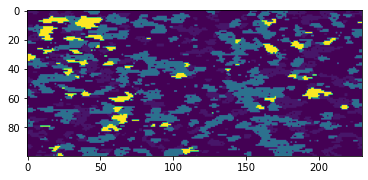


changing model workspace...
   F:/WRDAPP/GWFlowModel/Cosumnes/levee_setback/setback_distance_analysis/Permeameter_for_velocity/realization077/


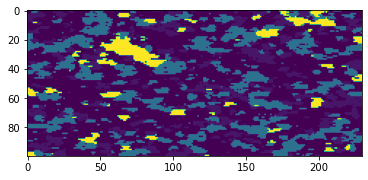


changing model workspace...
   F:/WRDAPP/GWFlowModel/Cosumnes/levee_setback/setback_distance_analysis/Permeameter_for_velocity/realization078/


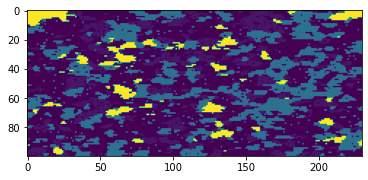


changing model workspace...
   F:/WRDAPP/GWFlowModel/Cosumnes/levee_setback/setback_distance_analysis/Permeameter_for_velocity/realization079/


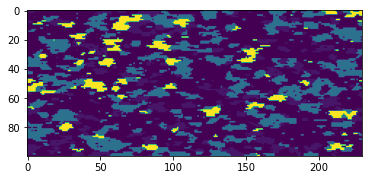


changing model workspace...
   F:/WRDAPP/GWFlowModel/Cosumnes/levee_setback/setback_distance_analysis/Permeameter_for_velocity/realization080/


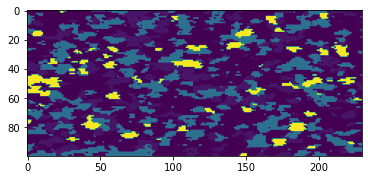


changing model workspace...
   F:/WRDAPP/GWFlowModel/Cosumnes/levee_setback/setback_distance_analysis/Permeameter_for_velocity/realization081/


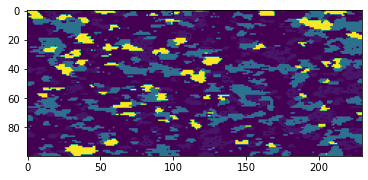


changing model workspace...
   F:/WRDAPP/GWFlowModel/Cosumnes/levee_setback/setback_distance_analysis/Permeameter_for_velocity/realization082/


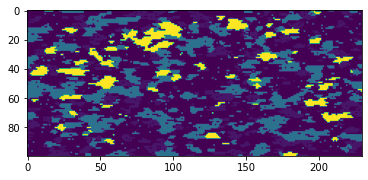


changing model workspace...
   F:/WRDAPP/GWFlowModel/Cosumnes/levee_setback/setback_distance_analysis/Permeameter_for_velocity/realization083/


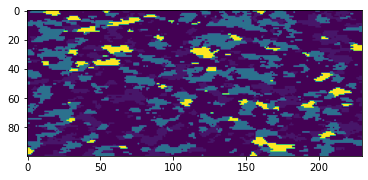


changing model workspace...
   F:/WRDAPP/GWFlowModel/Cosumnes/levee_setback/setback_distance_analysis/Permeameter_for_velocity/realization084/


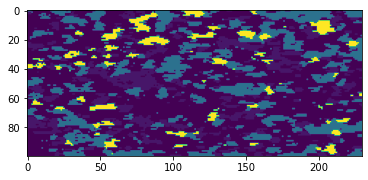


changing model workspace...
   F:/WRDAPP/GWFlowModel/Cosumnes/levee_setback/setback_distance_analysis/Permeameter_for_velocity/realization085/


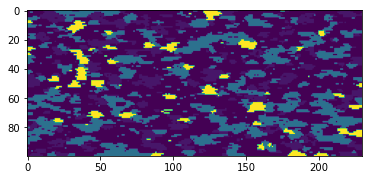


changing model workspace...
   F:/WRDAPP/GWFlowModel/Cosumnes/levee_setback/setback_distance_analysis/Permeameter_for_velocity/realization086/


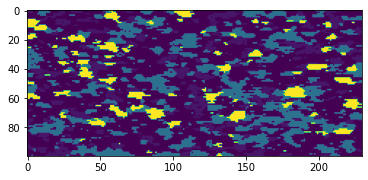


changing model workspace...
   F:/WRDAPP/GWFlowModel/Cosumnes/levee_setback/setback_distance_analysis/Permeameter_for_velocity/realization087/


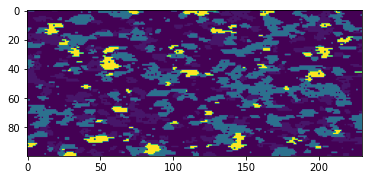


changing model workspace...
   F:/WRDAPP/GWFlowModel/Cosumnes/levee_setback/setback_distance_analysis/Permeameter_for_velocity/realization088/


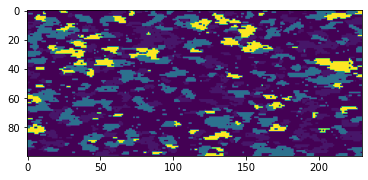


changing model workspace...
   F:/WRDAPP/GWFlowModel/Cosumnes/levee_setback/setback_distance_analysis/Permeameter_for_velocity/realization089/


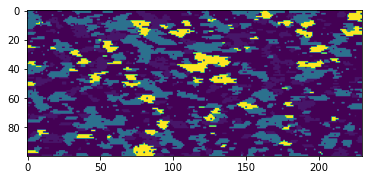


changing model workspace...
   F:/WRDAPP/GWFlowModel/Cosumnes/levee_setback/setback_distance_analysis/Permeameter_for_velocity/realization090/


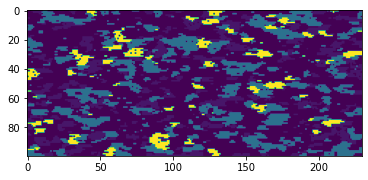


changing model workspace...
   F:/WRDAPP/GWFlowModel/Cosumnes/levee_setback/setback_distance_analysis/Permeameter_for_velocity/realization091/


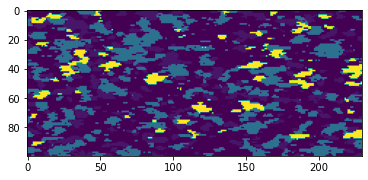


changing model workspace...
   F:/WRDAPP/GWFlowModel/Cosumnes/levee_setback/setback_distance_analysis/Permeameter_for_velocity/realization092/


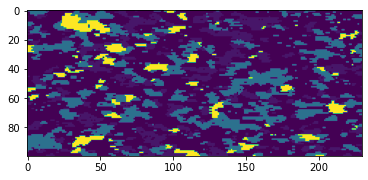


changing model workspace...
   F:/WRDAPP/GWFlowModel/Cosumnes/levee_setback/setback_distance_analysis/Permeameter_for_velocity/realization093/


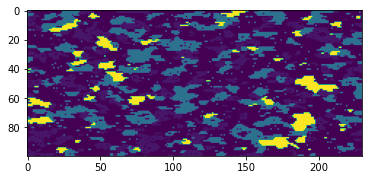


changing model workspace...
   F:/WRDAPP/GWFlowModel/Cosumnes/levee_setback/setback_distance_analysis/Permeameter_for_velocity/realization094/


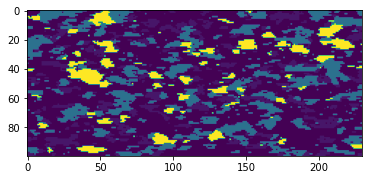


changing model workspace...
   F:/WRDAPP/GWFlowModel/Cosumnes/levee_setback/setback_distance_analysis/Permeameter_for_velocity/realization095/


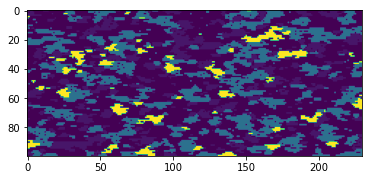


changing model workspace...
   F:/WRDAPP/GWFlowModel/Cosumnes/levee_setback/setback_distance_analysis/Permeameter_for_velocity/realization096/


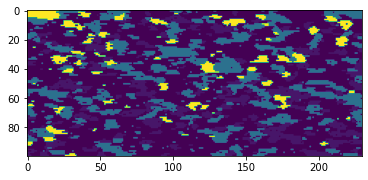


changing model workspace...
   F:/WRDAPP/GWFlowModel/Cosumnes/levee_setback/setback_distance_analysis/Permeameter_for_velocity/realization097/


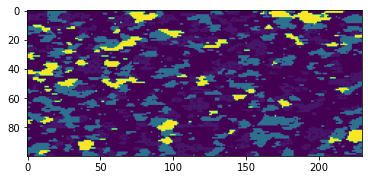


changing model workspace...
   F:/WRDAPP/GWFlowModel/Cosumnes/levee_setback/setback_distance_analysis/Permeameter_for_velocity/realization098/


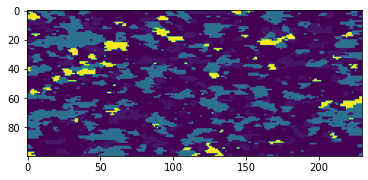


changing model workspace...
   F:/WRDAPP/GWFlowModel/Cosumnes/levee_setback/setback_distance_analysis/Permeameter_for_velocity/realization099/
Time: 7817.580317735672 (sec) or 130.29300529559453 (min)


In [14]:
tic = time.time()

for n in np.arange(0,100):
    tprogs_line = np.loadtxt(tprogs_files[n])
    tprogs_arr = np.reshape(tprogs_line, (320, 100,230))

    K, Sy, Ss= int_to_param(tprogs_arr, params)

    # # take of 2 for the bottom layers and 1 for the unsat zone layer up top
    # # for tprogs arrays 0 is the bottom of the model, so flipping on z will fix
    hk = np.flip(K,axis=0)
    #need to set anisotropy for TPROGs, may not matter for this
    vka = np.flip(K,axis=0)
    sy = np.flip(Sy,axis=0)
    ss = np.flip(Ss,axis=0)

#     plt.imshow(hk[0,:,:])
#     plt.show()
    # layvka 0 means vka is vert K, non zero means its the anisotropy ratio between horiz and vert
    layvka = 0

    # LAYTYP MUST BE GREATER THAN ZERO WHEN IUZFOPT IS 2
    # 0 is confined, >0 convertible, <0 convertible unless the THICKSTRT option is in effect
    # laytyp = np.ones(nlay)  
    laytyp = np.zeros(m.dis.nlay)
    # Laywet must be 0 if laytyp is confined laywet = [1,1,1,1,1]
    laywet = np.zeros(len(laytyp))
    laywet[laytyp==1] = 1
    #ipakcb = 55 means cell-by-cell budget is saved because it is non zero (default is 53)

    # until upscaling is begun then vertical and horiz K are the same for TPROGS
    # upw = flopy.modflow.ModflowUpw(model = m, hk =hk, layvka = layvka, vka = hk, sy=sy, ss=ss,
    #             laytyp=laytyp, ipakcb=55)
    m.model_ws = model_ws+'/realization'+ str(n).zfill(3)+'/'

    lpf = flopy.modflow.ModflowLpf(model = m, hk =hk, layvka = layvka, vka = hk, sy=sy, ss=ss,
                                   laytyp=laytyp, laywet = laywet, ipakcb=55)
#     plt.imshow(lpf.hk.array[0,:,:])
#     plt.show()
    lpf.write_file()
toc = time.time()
print('Time: '+str(toc-tic)+' (sec) or '+str((toc-tic)/60)+' (min)')
# takes 0.5 min per, so 50 minutes for all 100

In [62]:
print('Time: '+str(toc-tic)+' (s)? or '+str((toc-tic)/60)+' (min)')

Time: 31.995845317840576 (s)? or 0.5332640886306763 (min)


## Write out batch file to iterate over model runs

In [9]:
# import shutil, os
# # run_mf = 'mf2005.exe MF.nam\n PAUSE' #useful if running manually
# run_mf = 'mf2005.exe MF.nam\n'

# for n in np.arange(0,100).astype(str):
#     folder = '/realization'+ n.zfill(3)+'/'
#     f = open(model_ws+folder+"00_run_mf.bat", "w")
#     f.write(run_mf)
#     f.close()

In [7]:
# if the code is set up to run in order then it will all run automatically but in series so it will take 100 minutes
# if I can set up runners then it can run all at once or perhaps in sets

# this doesn't run from the correct folder
# If you want the bat to be run on an independent console: (i.e. another window)
# START CMD /C CALL "foo.bat" [args [...]]
# If you want the other window to hang around afterwards:
# START CMD /K CALL "foo.bat" [args [...]

# simple
# Start program1.exe
# Start program2.exe

In [9]:
import subprocess
n=str(0)
folder = '/realization'+ n.zfill(3)+'/'


# subprocess.call('cd '+ model_ws + folder, shell=True, check=True)
rv = subprocess.run('mf2005.exe MF.nam', shell=True, check=True, capture_output=True, cwd = model_ws + folder)

# 'cd '+ model_ws + folder

In [1]:
range(100)

range(0, 100)

In [17]:
# Open a file in write mode to open all runners
f = open(model_ws+"/00_run_all_parallel.bat", "w")

# write parallel runs
#100
for n in np.arange(0,100).astype(str):
    folder = '/realization'+ n.zfill(3)+'\\'
    f.write('cd '+ model_ws + folder+'\n')
#     f.write('Start 00_run_mf.bat' +'\n') # alternate if needed
    f.write('Start mf2005.exe MF.nam' +'\n')

    # close batch file now that all is written
f.close()

In [12]:
# run modflow line doesn't change between realizations because namefile is constant
run_mf_line = '\nmf2005.exe ' + m.name +'.'+ m.namefile_ext+'\n'

# Open a file in write mode to run through all folders
f = open(model_ws+"/00_run_all_series.bat", "w")

# iterate through all 100 directory names to use the batch file to change directory and run the next file
#100
for n in np.arange(0,100).astype(str):
    folder = '/realization'+ n.zfill(3)+'/'
    f.write('cd ' + model_ws +folder)
    f.write(run_mf_line)
# close batch file now that all is written
f.close()
